# ECE 420 Lab 5 – TD-PSOLA Pitch Synthesis


In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

# File paths
wav_file = "test_vector_all_voiced.wav"
epoch_file = "test_vector_all_voiced_epochs.npy"

Fs, audio_data = wav.read(wav_file)
audio_data = audio_data.astype(float)
N = len(audio_data)

epoch_marks_orig = np.load(epoch_file)

print(f"Sampling rate: {Fs} Hz")
print(f"Audio length: {N} samples")
print(f"Number of epochs: {len(epoch_marks_orig)}")


Sampling rate: 44100 Hz
Audio length: 170268 samples
Number of epochs: 797


## Visualize Waveform and Epoch Marks

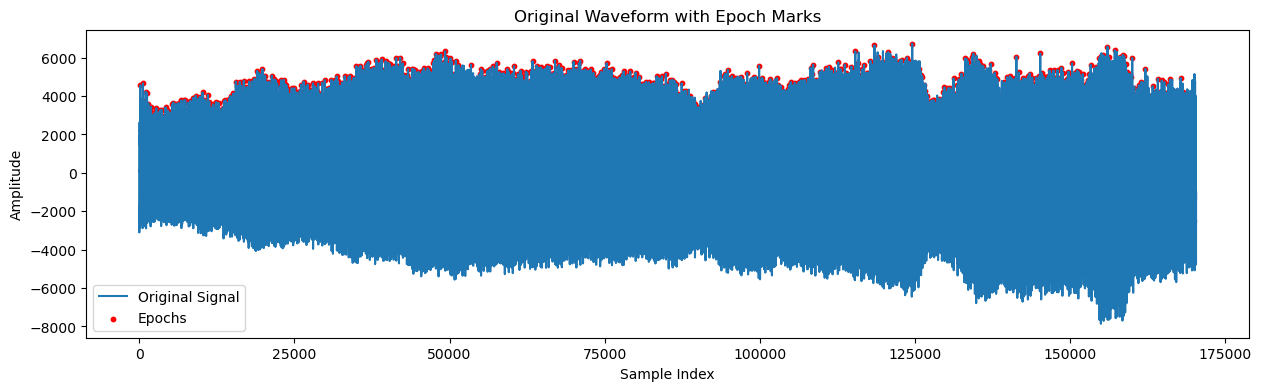

In [3]:
plt.figure(figsize=(15,4))
plt.plot(audio_data, label="Original Signal")
plt.scatter(epoch_marks_orig, audio_data[epoch_marks_orig], s=10, c='red', label="Epochs")
plt.legend()
plt.title("Original Waveform with Epoch Marks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


## Compute Local Period P0

In [5]:
P0_values = np.zeros(len(epoch_marks_orig))
for i in range(1, len(epoch_marks_orig)-1):
    P0_values[i] = (epoch_marks_orig[i+1] - epoch_marks_orig[i-1]) / 2

P0_mean = np.mean(P0_values[1:-1])
print(f"Average original period P0: {P0_mean:.2f} samples (~{Fs/P0_mean:.1f} Hz)")

Average original period P0: 212.30 samples (~207.7 Hz)


## 4. TD-PSOLA Implementation

In [7]:
def extract_windowed_epoch(epoch_idx, P0):
    start = int(epoch_idx - P0)
    end = int(epoch_idx + P0) + 1
    if start < 0 or end > len(audio_data):
        return None, None
    segment = audio_data[start:end]
    win = np.hanning(len(segment))
    return segment * win, start

def td_psola(F_new):
    P1 = int(Fs / F_new)
    audio_out = np.zeros_like(audio_data)
    new_epochs = np.arange(epoch_marks_orig[0], N, P1)

    for new_epoch in new_epochs:
        closest_idx = np.argmin(np.abs(epoch_marks_orig - new_epoch))
        orig_epoch = epoch_marks_orig[closest_idx]
        P0 = P0_values[closest_idx]

        windowed, start = extract_windowed_epoch(orig_epoch, P0)
        if windowed is None:
            continue

        end = start + len(windowed)
        audio_out[start:end] += windowed

    return audio_out / np.max(np.abs(audio_out))


## 5. Try Different Target Frequencies

In [9]:
for F_new in [100, 200, 300, 400]:
    out = td_psola(F_new)
    filename = f"td_psola_{F_new}Hz.wav"
    wav.write(filename, Fs, out.astype(np.float32))
    print(f"Saved: {filename}")


Saved: td_psola_100Hz.wav
Saved: td_psola_200Hz.wav
Saved: td_psola_300Hz.wav
Saved: td_psola_400Hz.wav
